# Motion Visualization Notebook

1. Setup
2. Build pipeline
3. Define helper functions
4. Load model and generate motion (from text)
5. Visualize motion (from file .npy)

In [1]:
# 1) Setup imports
import os
import sys
from os.path import join as pjoin

import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline

PYOM_DIR = "./datasets/pymo"
if PYOM_DIR not in sys.path:
    sys.path.insert(0, PYOM_DIR)

from pymo.parsers import BVHParser
from pymo.preprocessing import (
    MocapParameterizer,
    RootCentricPositionNormalizer,
    RootTransformer,
    ConstantsRemover,
    Numpyfier,
    DownSampler,
    ListStandardScaler,
)
from pymo.viz_tools import draw_stickfigure, draw_stickfigure3d

from models import MotionTransformer
from trainers import DDPMTrainer
from utils.get_opt import get_opt

# Paths
OPT_PATH = "./checkpoints/beat/beat_baseline/opt.txt"
CKPT_PATH = "./checkpoints/beat/beat_baseline/model/ckpt_e010.tar"
REF_BVH_PATH = "./datasets/2_scott_0_55_55.bvh"
OUTPUT_NPY = "./checkpoints/beat/beat_baseline/motion_010.npy"


In [2]:
# 2) Build and fit inverse pipeline from a reference BVH
pipeline = Pipeline([
    ("param", MocapParameterizer("position")),
    ("rcpn", RootCentricPositionNormalizer()),
    ("delta", RootTransformer("absolute_translation_deltas")),
    ("const", ConstantsRemover()),
    ("np", Numpyfier()),
    ("down", DownSampler(2)),
    ("stdscale", ListStandardScaler()),
])

if not os.path.exists(REF_BVH_PATH):
    raise FileNotFoundError(f"Reference BVH not found: {REF_BVH_PATH}")

parser = BVHParser()
ref_mocap_for_fit = parser.parse(REF_BVH_PATH)
pipeline.fit([ref_mocap_for_fit])
print("Pipeline fitted.")


/home/serverai/ltdoanh/Motion_Diffusion/./datasets/pymo/pymo/preprocessing.py:151: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  pos_df['%s_Yposition'%joint] = pd.Series(data=[e[1] for e in tree_data[joint][1]], index=pos_df.index)
/home/serverai/ltdoanh/Motion_Diffusion/./datasets/pymo/pymo/preprocessing.py:152: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  pos_df['%s_Zposition'%joint] = pd.Series(data=[e[2] for e in tree_data[joint][1]], index=pos_df.index)
/home/serverai/ltdoanh/Motion_Diffusion/./datasets/pymo/pymo/preproces

Pipeline fitted.


/home/serverai/ltdoanh/Motion_Diffusion/./datasets/pymo/pymo/preprocessing.py:150: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  pos_df['%s_Xposition'%joint] = pd.Series(data=[e[0] for e in tree_data[joint][1]], index=pos_df.index)
/home/serverai/ltdoanh/Motion_Diffusion/./datasets/pymo/pymo/preprocessing.py:151: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  pos_df['%s_Yposition'%joint] = pd.Series(data=[e[1] for e in tree_data[joint][1]], index=pos_df.index)
/home/serverai/ltdoanh/Motion_Diffusion/./datasets/pymo/pymo/preproces

In [3]:
# 3) Helper functions

def constrain_to_ref_skeleton(generated_mocap, ref_mocap):
    queue = [ref_mocap.root_name]
    gen_df = generated_mocap.values

    while queue:
        parent_name = queue.pop(0)
        children = ref_mocap.skeleton[parent_name]["children"]

        for child_name in children:
            if child_name not in generated_mocap.skeleton:
                continue

            ref_offset = np.array(ref_mocap.skeleton[child_name]["offsets"])
            target_bone_length = np.linalg.norm(ref_offset)
            if target_bone_length < 1e-6:
                queue.append(child_name)
                continue

            p_x = gen_df[f"{parent_name}_Xposition"]
            p_y = gen_df[f"{parent_name}_Yposition"]
            p_z = gen_df[f"{parent_name}_Zposition"]

            c_x = gen_df[f"{child_name}_Xposition"]
            c_y = gen_df[f"{child_name}_Yposition"]
            c_z = gen_df[f"{child_name}_Zposition"]

            vec_x = c_x - p_x
            vec_y = c_y - p_y
            vec_z = c_z - p_z

            current_lens = np.sqrt(vec_x**2 + vec_y**2 + vec_z**2)
            current_lens[current_lens == 0] = 1e-6
            scale_factor = target_bone_length / current_lens

            gen_df[f"{child_name}_Xposition"] = p_x + vec_x * scale_factor
            gen_df[f"{child_name}_Yposition"] = p_y + vec_y * scale_factor
            gen_df[f"{child_name}_Zposition"] = p_z + vec_z * scale_factor

            queue.append(child_name)

    return generated_mocap


def load_trainer(opt_path, ckpt_path):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    opt = get_opt(opt_path, device)
    opt.do_denoise = True

    encoder = MotionTransformer(
        input_feats=264,
        num_frames=360,
        num_layers=8,
        latent_dim=512,
        no_clip=False,
        no_eff=False,
    )

    trainer = DDPMTrainer(opt, encoder)
    trainer.load(ckpt_path)
    trainer.eval_mode()
    trainer.to(opt.device)

    mean = np.load(pjoin(opt.meta_dir, "mean.npy"))
    std = np.load(pjoin(opt.meta_dir, "std.npy"))
    return trainer, opt, mean, std


def generate_motion_to_npy(trainer, text, motion_len, save_path, feat_dim=264):
    with torch.no_grad():
        lens = torch.LongTensor([motion_len]).to(trainer.device)
        pred = trainer.generate([text], lens, feat_dim)
        motion = pred[0].cpu().numpy()
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    np.save(save_path, motion)
    print(f"Saved generated motion: {save_path}, shape={motion.shape}")
    return motion


def visualize_npy(npy_file, mean, std, pipeline, ref_bvh_path, frames=(0, 50, 100)):
    if not os.path.exists(npy_file):
        raise FileNotFoundError(f"Npy file not found: {npy_file}")

    m_model = np.load(npy_file)
    m_denorm = m_model * std + mean

    mocap = pipeline.inverse_transform([m_denorm])[0]
    ref_mocap = BVHParser().parse(ref_bvh_path)
    mocap = constrain_to_ref_skeleton(mocap, ref_mocap)

    fig = plt.figure(figsize=(18, 10))
    for i, f in enumerate(frames):
        frame_idx = min(f, len(mocap.values) - 1)

        ax2d = fig.add_subplot(2, 3, i + 1)
        draw_stickfigure(mocap, frame=frame_idx, ax=ax2d)
        ax2d.set_title(f"2D - Frame {frame_idx}")

        ax3d = fig.add_subplot(2, 3, i + 4, projection="3d")
        draw_stickfigure3d(mocap, frame=frame_idx, ax=ax3d)
        ax3d.set_title(f"3D - Frame {frame_idx}")

    plt.tight_layout()
    plt.show()

    return mocap


In [4]:
# 4) Load model and optionally generate one sample from text
trainer, opt, mean, std = load_trainer(OPT_PATH, CKPT_PATH)

text_prompt = "because when you have work monday to friday the whole week you're very tired"
motion_len = 300

_ = generate_motion_to_npy(
    trainer=trainer,
    text=text_prompt,
    motion_len=motion_len,
    save_path=OUTPUT_NPY,
    feat_dim=264,
)


Reading ./checkpoints/beat/beat_baseline/opt.txt


/srv/conda/envs/serverai/motiondiff/lib/python3.9/site-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/srv/conda/envs/serverai/motiondiff/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 1000/1000 [00:20<00:00, 49.95it/s]

Saved generated motion: ./checkpoints/beat/beat_baseline/motion_010.npy, shape=(300, 264)


/home/serverai/ltdoanh/Motion_Diffusion/./datasets/pymo/pymo/preprocessing.py:595: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df['%s_Yposition'%joint] = pd.Series(data=track.values['%s_Yposition'%joint]+projected_root_pos[ryp], index=new_df.index)
/home/serverai/ltdoanh/Motion_Diffusion/./datasets/pymo/pymo/preprocessing.py:596: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df['%s_Zposition'%joint] = pd.Series(data=track.values['%s_Zposition'%joint]+projected_root_pos[rzp], index=new_df.index)
/home/serverai/ltdoanh/M

positions 2 eulers is not supported


/home/serverai/ltdoanh/Motion_Diffusion/./datasets/pymo/pymo/viz_tools.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.scatter(x=df['%s_Xposition'%joint][frame],
/home/serverai/ltdoanh/Motion_Diffusion/./datasets/pymo/pymo/viz_tools.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y=df['%s_Yposition'%joint][frame],
/home/serverai/ltdoanh/Motion_Diffusion/./datasets/pymo/pymo/viz_tools.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `

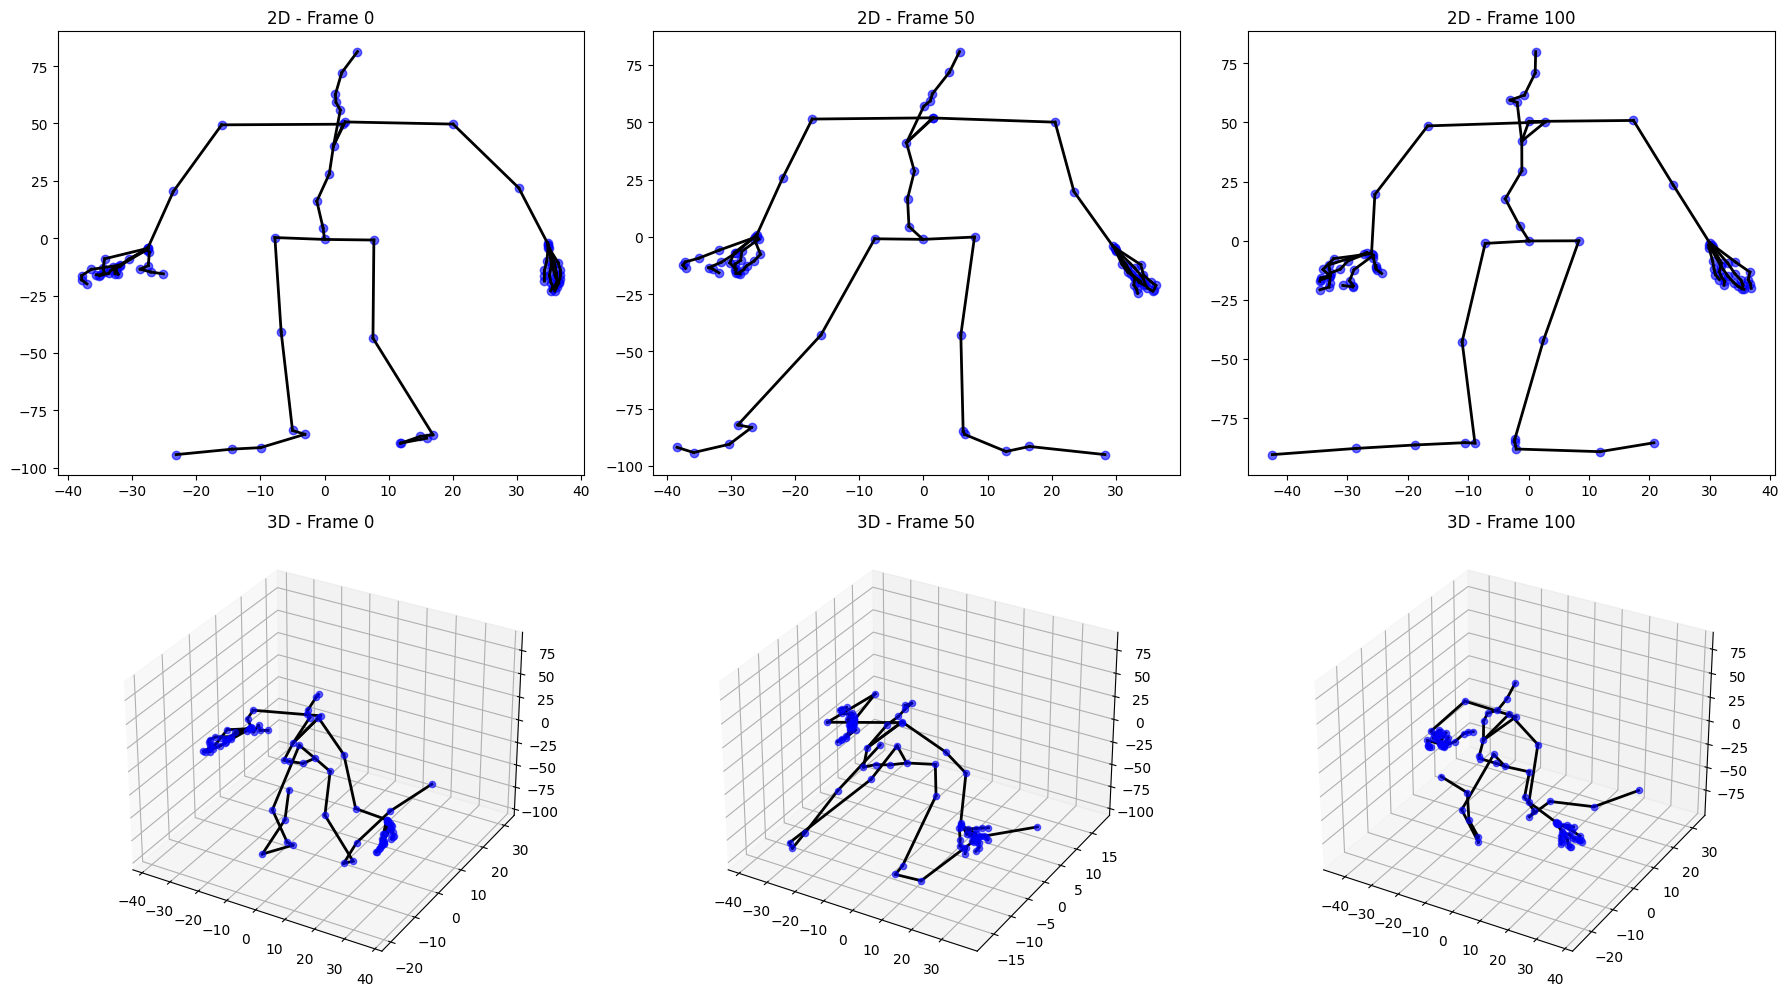

In [5]:
# 5) Visualize generated output
_ = visualize_npy(
    npy_file=OUTPUT_NPY,
    mean=mean,
    std=std,
    pipeline=pipeline,
    ref_bvh_path=REF_BVH_PATH,
    frames=(0, 50, 100),
)

In [6]:
# 6) Optional: visualize an existing BEAT sample (.npy)
# Uncomment and edit path if needed.

# sample_npy = "./datasets/BEAT_numpy/npy/1/1_wayne_0_1_1_sentence_000.npy"
# _ = visualize_npy(
#     npy_file=sample_npy,
#     mean=mean,
#     std=std,
#     pipeline=pipeline,
#     ref_bvh_path=REF_BVH_PATH,
#     frames=(0, 50, 100),
# )
